In [16]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3767, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3767 (delta 0), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3767/3767), 143.05 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
directory = 'Face-Mask-Detection/dataset'
categories = ['with_mask', 'without_mask']

data = []
labels = []

for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype='float32')
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=222)

In [10]:
augment = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
mobileNet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = mobileNet.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=mobileNet.input, outputs=headModel)

In [19]:
lr = 1e-4
epochs = 20
bs = 32

In [21]:
#freeze some layers
for layer in mobileNet.layers:
  layer.trainable = False

optmizer = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss='binary_crossentropy', optimizer=optmizer, metrics=['accuracy'])

In [22]:
history = model.fit(augment.flow(X_train, y_train, batch_size=bs), steps_per_epoch=len(X_train)//bs, validation_data=(X_test, y_test),
                    validation_steps=len(X_test//bs), epochs=epochs)

Epoch 1/20
95/95 [==============================] - 49s 413ms/step - loss: 0.4210 - accuracy: 0.8425 - val_loss: 0.1701 - val_accuracy: 0.9752
Epoch 2/20
95/95 [==============================] - 35s 369ms/step - loss: 0.1621 - accuracy: 0.9634 - val_loss: 0.0926 - val_accuracy: 0.9778
Epoch 3/20
95/95 [==============================] - 36s 378ms/step - loss: 0.1028 - accuracy: 0.9763 - val_loss: 0.0680 - val_accuracy: 0.9831
Epoch 4/20
95/95 [==============================] - 35s 371ms/step - loss: 0.0804 - accuracy: 0.9796 - val_loss: 0.0577 - val_accuracy: 0.9831
Epoch 5/20
95/95 [==============================] - 35s 368ms/step - loss: 0.0747 - accuracy: 0.9822 - val_loss: 0.0520 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 36s 376ms/step - loss: 0.0658 - accuracy: 0.9835 - val_loss: 0.0504 - val_accuracy: 0.9844
Epoch 7/20
95/95 [==============================] - 45s 477ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.0467 - val_accuracy: 0.9870

In [23]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_3 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [24]:
predections = model.predict(X_test, batch_size= bs)

predections = np.argmax(predections, axis = 1)

In [25]:
print(classification_report(y_test.argmax(axis=1), predections, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       383
without_mask       1.00      0.99      1.00       384

    accuracy                           1.00       767
   macro avg       1.00      1.00      1.00       767
weighted avg       1.00      1.00      1.00       767



In [26]:
model.save('mask_detector.model', save_format='h5')

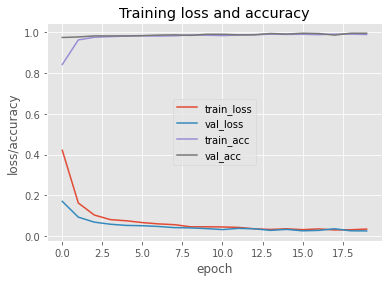

In [29]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(epochs), history.history['val_accuracy'], label = 'val_acc')
plt.title('Training loss and accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend(loc='center')
plt.show()